[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/colab_notebooks/blob/master/kaggle_tgs_salt_identification.ipynb)

### Kaggle notebook
For *TGS Salt identification* competition:

https://www.kaggle.com/c/tgs-salt-identification-challenge

# Setup kaggle and download dataset

In [0]:
!pip install kaggle

In [2]:
## Load Kaggle config JSON
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Download 100%.


In [3]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 62.8MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 70.5MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 92.9MB/s]
 94% 154M/163M [00:00<00:00, 150MB/s]
100% 163M/163M [00:00<00:00, 186MB/s]
 92% 35.0M/37.9M [00:00<00:00, 42.2MB/s]
100% 37.9M/37.9M [00:00<00:00, 78.5MB/s]


In [4]:
!ls

adc.json    sample_data		   test.zip   train.zip
depths.csv  sample_submission.csv  train.csv


In [0]:
!unzip -q train.zip
!unzip -q test.zip

# Install Dependencies

In [6]:
!pip install -q imageio
!pip install -q torch

tcmalloc: large alloc 1073750016 bytes == 0x590d2000 @  0x7fa2b66e71c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
!pip install -q ipywidgets

In [0]:
import os
import numpy as np

import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data

# Create class for input dataset

In [0]:
class TGSSaltDataSet(data.Dataset):
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        file_id = self.file_list[index]
        
        # Image folder
        image_folder = os.path.join(self.root_path, 'images')
        image_path = os.path.join(image_folder, file_id+ '.png')
        
        # Label folder
        mask_folder = os.path.join(self.root_path, 'masks')
        mask_path = os.path.join(mask_folder, file_id+ '.png')
        
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        
        return image, mask

# Load dataset csv

In [0]:
train_mask = pd.read_csv('train.csv')
depth = pd.read_csv('depths.csv')

train_path = './'

file_list = list(train_mask['id'].values)

dataset = TGSSaltDataSet(train_path, file_list)

# Visualize dataset

In [0]:
def plot2x2array(image, mask):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image)
    axs[1].imshow(mask)
    
    axs[0].grid()
    axs[1].grid()
    
    axs[0].set_title('Image')
    axs[1].set_title('Mask')

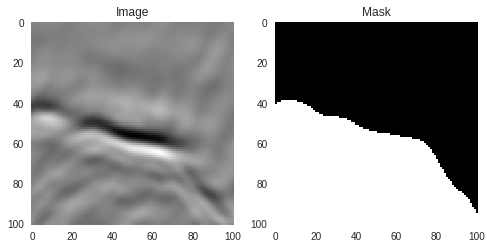

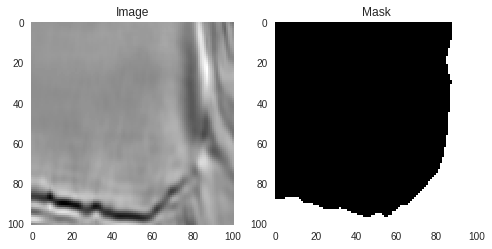

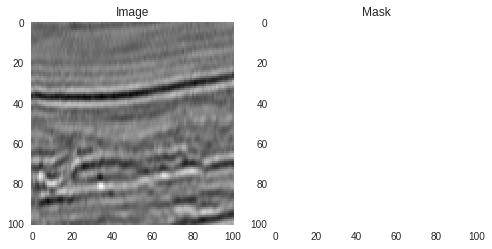

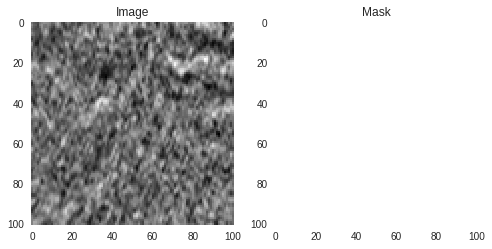

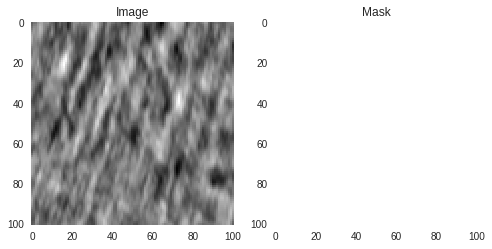

In [23]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2array(image, mask)

Text(0.5,1,'Depth distribution')

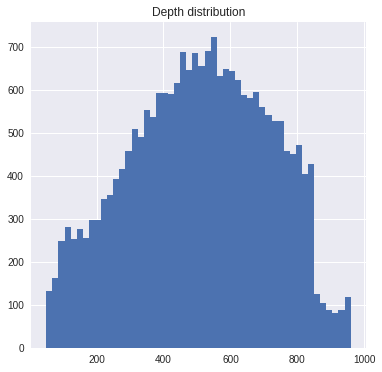

In [24]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')

# Convert RLE Mask to matrix

In [0]:
def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    try:
        rle_numbers = [int(numstr) for numstr in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        img = np.zeros(rows * cols, dtype=np.uint8)
        
        for idx, length in rle_pairs:
            idx -= 1
            img[idx:idx+length] = 255
            
        img = img.reshape(cols, rows)
        
        img = img.T
        
    except:
        img = np.zeros((cols, rows))
        
    return img

In [0]:
def salt_proportion(img_array):
    try:
        unique, counts = np.unique(img_array, return_counts=True)
        return counts[1]/10201.
    except:
        return 0.0

# Create training mask

In [0]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rle_to_mask(x, 101, 101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))


# Let's merge the mask and depths

In [28]:
merged = train_mask.merge(depth, how='left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt vs depth')

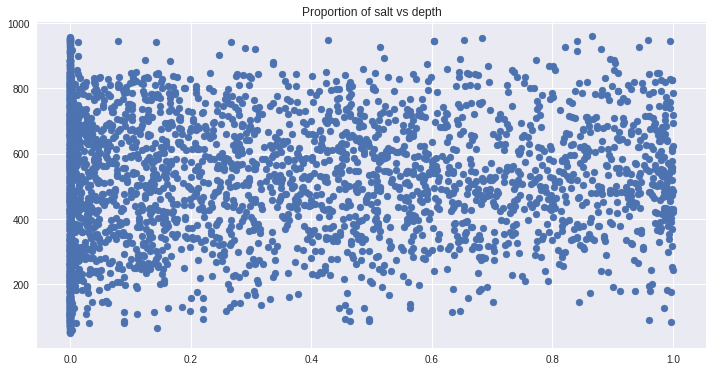

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt vs depth')